In [87]:
import os
import copy
from copy import deepcopy
import math
import natsort
import random
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorwatch as tw
import torchsnooper as ts
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchOTE.data import process_spot_rate as psr
from torchOTE.data import process_grud_data as pgd
from torchOTE.torch_data.datasets import RegularFinancialData, GRUDFinancialData
from torchOTE.torch_data.utils import one_hot
from torchOTE.torch_data.metrics import weighted_cross_entropy_accuracy
from torchOTE.models.grud import GRUD
from torchOTE.models.mlp import MLP
from torchOTE.models.modules import *

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In this notebook we expand on the work done in `12_lstm_on_expert_volume_data`.
We perform **behavior cloning** [paper](https://www.ijcai.org/proceedings/2018/0687.pdf), [intro slides](http://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-2.pdf) without the use of reinforcement learning modules or learning algorithms. 
Traditionally, direct behavior cloning is finnicky due to the so-called policy divergence effect, where small errors in the imitation policy cause the agent to end up in previously unexplored states, thus causing the error effect to compound over time during the rollout (a possible [fix](https://www.cs.cmu.edu/~sross1/publications/Ross-AIStats11-NoRegret.pdf)). In our setting the underlying environment dynamics are assumed to to be conditionally independent of our trading agent's actions given the previous state (i.e $p(s_{t+1}|s_{t}, a_{t}) = p(s_{t+1}|s_{t})$)
Previous results with one autoregressive imitation architecture (`LSTM-I` LSTM Imitation) are improved by introducing an ensemble of predictors (`LSTM-IE` LSTM Imitation Ensemble)

##### Data Reading:

In [21]:
PATH = Path('../../data/sorted_filtered_dtcc').resolve()
state = pd.read_pickle(f'{PATH}/state_logretfilter_returns_distill')
usdkrwvol = pd.read_pickle(f'{PATH}/usdkrw_volume_quantized')
all_vols = pd.read_pickle(f'{PATH}/all_currs_volumes_quantized')

# Data manipulation

We aggregate tenors in bins of `10` (e.g 1 days to 10, 11 to 20, etc). For comparison, both model and expert data will be assumed to take actions in this quantized space: bin `1` will correspond to a buy order at tenor 10, for example. This will cause the expert data to perform slightly worse due to the loss in resolution (e.g when expert trades with positive return at tenor 84 happen to have a negative return at 80, for example).

In [22]:
# aggregate all vols in first column of each tenor bin 
for i in range(0, 9, 1):
    usdkrwvol.iloc[:,10*i] = usdkrwvol.iloc[:,10*i:10*(i+1)].sum(axis=1)
# grab first col of each curr where vol has been aggregated
usdkrwvol =  usdkrwvol.iloc[:, np.arange(0, 90, 10)]
# bool feat
usdkrwvol = usdkrwvol > 0
# to 0/-1
usdkrwvol = usdkrwvol.astype(int) * -1
# add column for no volume 
usdkrwvol['USDKRW_no'] = -1
# multiply each column by *j*, where *j* corresponds to its index in the column sequence
for j in range(len(usdkrwvol.columns)):
    usdkrwvol.iloc[:, j] = usdkrwvol.iloc[:, j] * (j+1)
# find row-wise maximum exluding 0s and multiply -1 to get labels
usdkrwvol = usdkrwvol[usdkrwvol!=0].max(axis=1) * -1
# shift by -1 (0 -> tenor 1-10, 1 -> tenor 11-20 ... 9 -> no trade)
labels = (usdkrwvol - 1).values
# reread one-hot dataset (X)
usdkrwvol = pd.read_pickle(f'{PATH}/usdkrw_volume_quantized')
# append labels
usdkrwvol['labels'] = labels
# order labels for consistency (0: `Hold`, 1: `Buy<10d` etc.)
usdkrwvol['labels'].replace({9: 0, 0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9}, inplace=True)

In [23]:
usdkrwvol['labels'].value_counts()

0.0    698
1.0    336
4.0    160
2.0     81
3.0     79
6.0     50
7.0     37
5.0     35
9.0     34
8.0     28
Name: labels, dtype: int64

## Data prep

In [24]:
# pre-aggregation
print(usdkrwvol['labels'].value_counts())

to_split_data = usdkrwvol.iloc[:-107]
tr, val = to_split_data.iloc[:1008].fillna(0), to_split_data.iloc[1008:].fillna(0)


ttr = torch.Tensor(tr.values).to(device)
tval = torch.Tensor(val.values).to(device)

# to tensor
ttr = torch.Tensor(tr.iloc[:, :].values)
tval = torch.Tensor(val.iloc[:, :].values)

mu = 10
freqs = []
for i in range(mu):
    freq = float(torch.sum(ttr[:,-1]==i))/float(torch.numel(ttr[:,-1]))
    freqs.append(freq)
    print(f'{round(freq*100,2)} % of the training data contain `{i}`')
    
inv_freqs = 1/torch.Tensor(freqs)
weights = inv_freqs/sum(inv_freqs)

0.0    698
1.0    336
4.0    160
2.0     81
3.0     79
6.0     50
7.0     37
5.0     35
9.0     34
8.0     28
Name: labels, dtype: int64
46.63 % of the training data contain `0`
21.13 % of the training data contain `1`
3.47 % of the training data contain `2`
4.96 % of the training data contain `3`
10.91 % of the training data contain `4`
1.88 % of the training data contain `5`
3.87 % of the training data contain `6`
2.38 % of the training data contain `7`
2.28 % of the training data contain `8`
2.48 % of the training data contain `9`


# Handling class imbalance

To handle the issue of label imbalance inverse frequency weights are computed and used in a `WeightedSampler` to perform oversampling of underrepresented tenor labels.

In [26]:
len_slice = 10
# higher sampling weight to samples with volume label at idx + len_slice != 0
num_slices_tr = len(ttr) - len_slice
num_slices_val = len(tval) - len_slice

# weights to be computed for the last column -> labels
labels_tr = deepcopy(ttr[:,-1])
labels_val = deepcopy(tval[:,-1])

# in-place op
labels_tr.apply_(lambda x: weights[int(x)])
labels_val.apply_(lambda x: weights[int(x)])

# shift left by `len_slice` weights.
# need samples with high volume at the **end** of the slice (of length `len_slice`)
# summing across tenors (higher probability to samples with high volume labels across tenor lengths)
labels_tr = labels_tr[len_slice:]
labels_val = labels_val[len_slice:]

In [276]:
from torch.utils.data import WeightedRandomSampler, RandomSampler
bs = 256

trainloader = DataLoader(RegularFinancialData(ttr, len_slice),
                         batch_size=bs,
                         sampler=WeightedRandomSampler(labels_tr, len(ttr), replacement=True),
                         )

valloader = DataLoader(RegularFinancialData(tval, len_slice), 
                       batch_size=len(tval), shuffle=False)

## Training the ensemble

In [ ]:
ensemble_size=25
ensemble = []

for model in range(ensemble_size):
    m = RecurrentWrapper(rec_cell_type='LSTM',
                         recurrent_layers=[90, 90], 
                         mlp_in_dim=90, 
                         mlp_out_dim=10, 
                         mlp_layers=[128, 128],
                         dropout_prob=0.4,
                        ).to(device)

    opt = torch.optim.Adam(m.parameters(), lr=0.005)
    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=1000)
    m.fit(epochs=2500, 
          trainloader=trainloader, 
          valloader=valloader, 
          opt=opt, 
          sched=sched, 
          device=device, 
          log_interval=100000, 
          weighted=True, 
          weights=weights, 
          dropout_schedule=[0.4, 0.3, 0.2, 0.1, 0], 
          dropout_interval=1000
          )
    
    ensemble.append(m)

## Actions Visualization: Validation Data

The plots below show the actions taken by experts and ensemble during different trading days in the validation window. The expert data is filtered for **positive** trades only: however, due to the loss in resolution of the tenor (1 to 90, daily -> 1 to 90, bins of 10 days) some expert actions appear to be located on a negative return area. Quantizing the tenor length helps with data sparsity but adds noise to the expert data from the model's perspective.

In [305]:
# raw spots
PATH = os.path.realpath('../../data')
d = pd.read_csv('{}/fx.csv'.format(PATH), index_col='Date')
d.index = pd.to_datetime(d.index)

# raw returns vs quantized returns aligned with volume
# dropped some rows (10 initial) in quantized returns 
# used for volume data
# hacky alignment
d = d[10:]

# remove dropout
for model in ensemble:
    model.MLP.drop_probability = 0.

it = next(iter(valloader))
probs = torch.zeros(it.size(0), 10).to(device)
for model in ensemble:
    probs += model(it[:,:-1,:-1].to(device))
_, predictions = torch.max(probs/len(ensemble), 1)


probs = ensemble[18](it[:,:-1,:-1].to(device))
_, predictions = torch.max(probs, 1)
    
# validation data indices: 1008:-107 -> len = 423
# to get future returns for the last days in the validation dataset
# we keep all data indexed [1008:] -> len = 530
len_input_slice = 10
ret = d['USDKRW'].iloc[1008:] 
rets = ret.pct_change(1).dropna()[len_input_slice:423].values[None, :]
for i in range(2,91):
    rets = np.concatenate((rets, ret.pct_change(i).dropna()[len_input_slice:423].values[None, :]), axis=0)

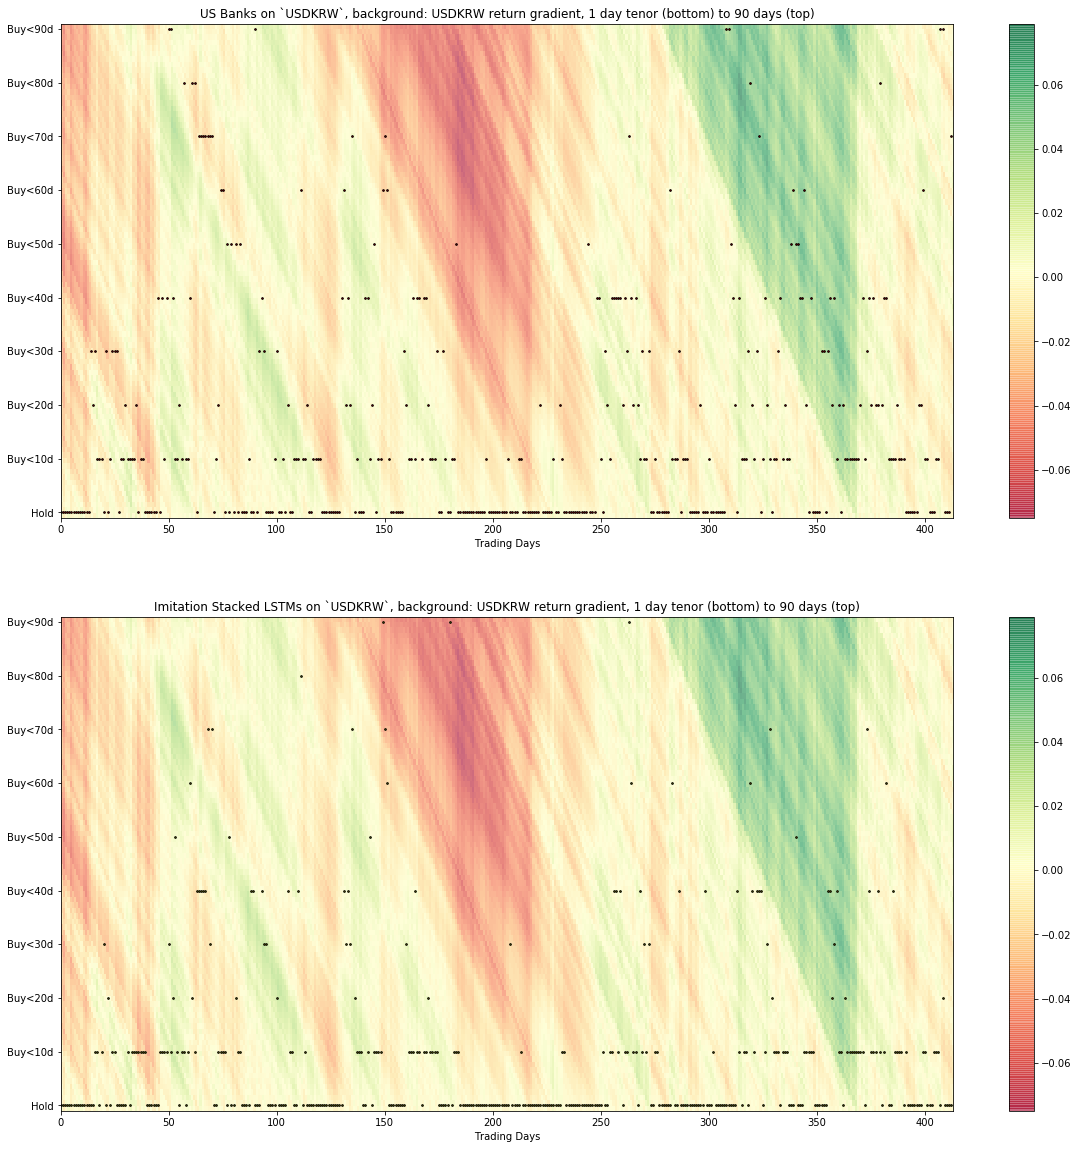

In [306]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(211)
ax.scatter(list(range(len(it[:,-1,-1]))),
        it[:,-1,-1].cpu().numpy(), alpha=1, color='r', edgecolor='black' , s=2.7);
im = ax.imshow(rets, alpha=0.6, cmap='RdYlGn', aspect='auto', origin='lower', extent=[0,413,-0.1,9.1])
plt.colorbar(im)
ax.set_yticks(np.arange(0, 10, 1))
ax.set_yticklabels(['Hold', 'Buy<10d', 'Buy<20d', 'Buy<30d', 'Buy<40d', 'Buy<50d', 'Buy<60d', \
                    'Buy<70d', 'Buy<80d', 'Buy<90d'])
ax.set_xlabel('Trading Days')
plt.title('US Banks on `USDKRW`, background: USDKRW return gradient, 1 day tenor (bottom) to 90 days (top)')

ax = plt.subplot(212)
ax.scatter(list(range(len(it[:,-1,-1]))), 
         predictions.cpu().numpy(), alpha=1, color='y', edgecolor='black', s=2.7)
im = ax.imshow(rets, alpha=0.6, cmap='RdYlGn', aspect='auto', origin='lower', extent=[0,413,-0.1,9.1])
plt.colorbar(im)
ax.set_yticks(np.arange(0, 10, 1))
ax.set_yticklabels(['Hold', 'Buy<10d', 'Buy<20d', 'Buy<30d', 'Buy<40d', 'Buy<50d', 'Buy<60d', \
                    'Buy<70d', 'Buy<80d', 'Buy<90d'])
ax.set_xlabel('Trading Days')
plt.title('Imitation Stacked LSTMs on `USDKRW`, background: USDKRW return gradient, 1 day tenor (bottom) to 90 days (top)')
plt.savefig('untrained SLSTM-I, trades.jpg')

### PCA of average ensemble LSTM latents

The following plots are obtained by applying PCA to a sample of the latent space of the model's last recurrent block obtained from the validation data.

In [341]:
latents = torch.zeros(it[:,:-1,:-1].size(0), 90).to(device)
for model in ensemble:
    h = Hook(model._modules['MLP'])
    it = next(iter(valloader))
    probs = model(it[:,:-1,:-1].to(device))
    _, predictions = torch.max(probs, 1)
    latents += h.input[0]
    
latents = latents/len(ensemble)

idxs = []
for i in range(10):
    idxs.append((it[:,-1,-1]==i).nonzero())

The last recurrent layer uses most of its dimensions for learning (i.e no collapse to line attractor).
Explained variance > 85% requires at least 50 principal components. This is in contrast with previous results on the problem of `Hold vs Buy` in `12_lstm_on_expert_volume_data` where the latent space collapsed into a separable 1-dimensional space, indicating a lack of complexity in the input data (series of 0-1 labels for expert `Hold` or `Buy` actions without additional information about tenor or volume).

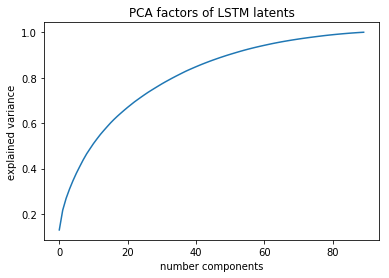

In [342]:
#n components:
pca = PCA(90)
emb = pca.fit_transform(latents.detach().cpu().numpy())
c = pca.explained_variance_ratio_
plt.plot(np.cumsum(c))
plt.ylabel('explained variance')
plt.xlabel('number components')
plt.title('PCA factors of LSTM latents')
plt.savefig('trained SLSTM-I, latent PCA.jpg')

No single pair of PCA factors shows easily separable data, which means the model is learning a non-trivial mapping from previous expert activity to tenor labels. Different colors indicate different tenor labels.

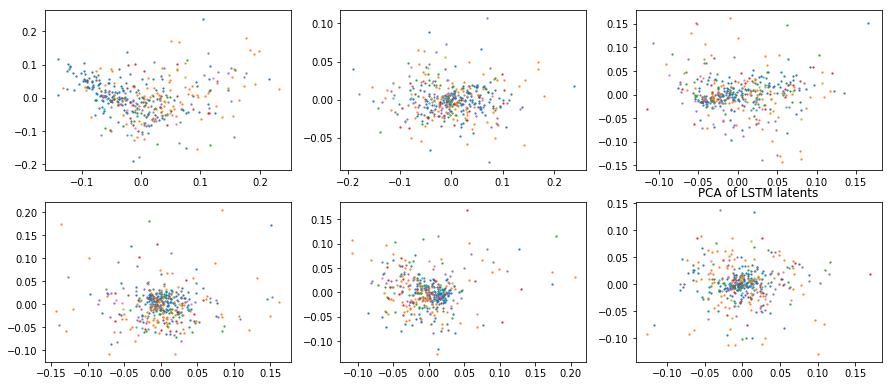

In [347]:
# pair scatters for first 6 PCA dimensions
plt.figure(figsize=(15,10))
plt.subplot(331)
for i in range(10):
    plt.scatter(emb[idxs[i],0], emb[idxs[i], 1], s=1.8, alpha=0.8);
plt.subplot(332)
for i in range(10):
    plt.scatter(emb[idxs[i],1], emb[idxs[i], 21], s=1.8, alpha=0.8);
plt.subplot(333)
for i in range(10):
    plt.scatter(emb[idxs[i],2], emb[idxs[i], 3], s=1.8, alpha=0.8);
plt.subplot(334)
for i in range(10):
    plt.scatter(emb[idxs[i],3], emb[idxs[i], 4], s=1.8, alpha=0.8);
plt.subplot(335)
for i in range(10):
    plt.scatter(emb[idxs[i],4], emb[idxs[i], 5], s=1.8, alpha=0.8);
plt.subplot(336)
for i in range(10):
    plt.scatter(emb[idxs[i],5], emb[idxs[i], 6], s=1.8, alpha=0.8);
plt.title('PCA of LSTM latents');

## Effectiveness: ROI and Activity on Validation Data

In [375]:
it = next(iter(valloader))
probs = torch.zeros(it.size(0), 10).to(device)
for model in ensemble:
    probs += model(it[:,:-1,:-1].to(device))
_, predictions = torch.max(probs/len(ensemble), 1)

In [391]:
return_model = 0
for idx, el in enumerate(predictions):
    #if action not `Hold`
    if el != 0:
        action = el * 10 -1 # buy at label * 10 (tenors bin size: 10)
        return_model += rets[action, idx]
ensemble_ret = return_model
ensemble_ret

0.6548286901836462

In [392]:
return_labels = 0
for idx, el in enumerate(it[:, -1, -1].flatten()):
    #if action not `Hold`
    if el != 0:
        action = int(el) * 10 -1 # buy at label * 10 (tenors bin size: 10)
        return_labels += rets[action, idx]
return_labels

1.136454286952143

In [378]:
return_random = 0
for idx in range(len(it)):
    action = np.random.choice(np.arange(0,10),1, replace=True)
    return_random += rets[action, idx]
return_random

array([-0.33968278])

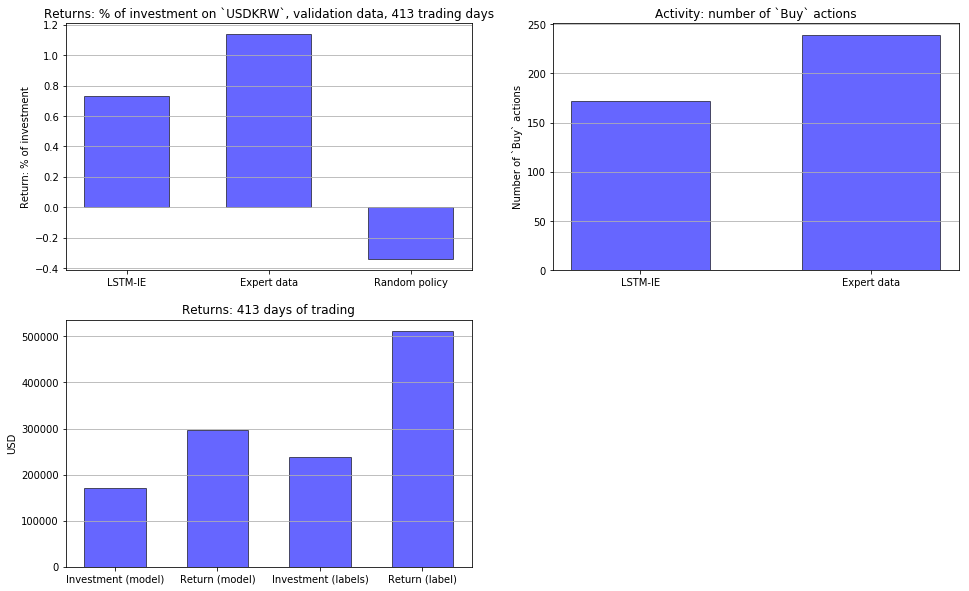

In [379]:
# n_trades:
activity_labels = torch.numel(it[:,-1,-1].nonzero()),
activity_model = torch.numel(b.nonzero())
activity_labels = activity_labels[0]

order_size = 1000

im = plt.figure(figsize=(16,10))
plt.subplot(221)
plt.bar(np.arange(0, 3, 1), [return_model, return_labels, return_random], \
        width=0.6, color='blue', edgecolor='black', alpha=0.6)

plt.xticks(ticks=[0, 1, 2], labels=['LSTM-IE', 'Expert data', 'Random policy']);
plt.ylabel('Return: % of investment')
plt.grid(axis='y')
plt.title('Returns: % of investment on `USDKRW`, validation data, 413 trading days')
plt.subplot(222)
plt.bar(np.arange(0, 2, 1), [activity_model, activity_labels], width=0.6, color='blue', \
        edgecolor='black', alpha=0.6)

plt.xticks(ticks=[0, 1], labels=['LSTM-IE', 'Expert data']);
plt.ylabel('Number of `Buy` actions')
plt.grid(axis='y')
plt.title('Activity: number of `Buy` actions')


plt.subplot(223)
plt.bar(np.arange(0, 4, 1), [order_size*activity_model, \
                             order_size*(1+return_model)*activity_model, \
                             order_size*activity_labels, \
                             order_size*(1+return_labels)*activity_labels], \
        width=0.6, color='blue', edgecolor='black', alpha=0.6)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Investment (model)', 'Return (model)', 'Investment (labels)', \
                                      'Return (label)']);
plt.ylabel('USD')
plt.grid(axis='y')
plt.title('Returns: 413 days of trading')
plt.savefig('trained SLSTM-I.jpg')

## Effectiveness: single model vs ensemble

Same plots with the best model in the ensemble:

In [380]:
it = next(iter(valloader))
perfs = []

probs = torch.zeros(it.size(0), 10).to(device)
for model in ensemble:
    probs = model(it[:,:-1,:-1].to(device))
    _, predictions = torch.max(probs, 1)

    return_model = 0
    for idx, el in enumerate(predictions):
        #if action not `Hold`
        if el != 0:
            action = el * 10 -1 # buy at label * 10 (tenors bin size: 10)
            return_model += rets[action, idx]
    perfs.append(return_model)

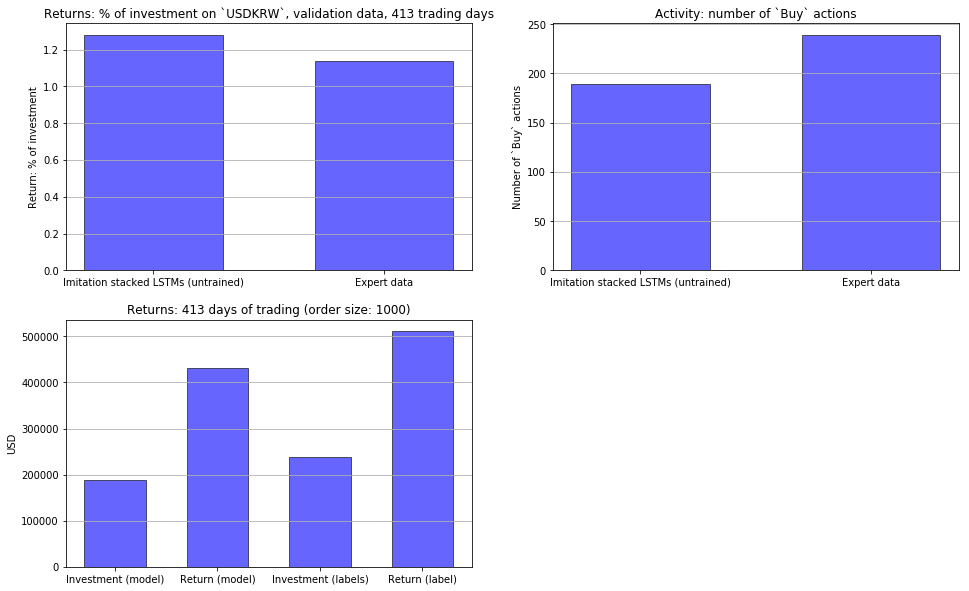

In [382]:
return_model = np.array(perfs).max()
# n_trades:
activity_labels = torch.numel(it[:,-1,-1].nonzero()),
activity_model = torch.numel(predictions.nonzero())
activity_labels = activity_labels[0]

order_size = 1000

im = plt.figure(figsize=(16,10))
plt.subplot(221)
plt.bar(np.arange(0, 2, 1), [return_model, return_labels], \
        width=0.6, color='blue', edgecolor='black', alpha=0.6)

plt.xticks(ticks=[0, 1], labels=['Imitation stacked LSTMs (untrained)', 'Expert data']);
plt.ylabel('Return: % of investment')
plt.grid(axis='y')
plt.title('Returns: % of investment on `USDKRW`, validation data, 413 trading days')
plt.subplot(222)
plt.bar(np.arange(0, 2, 1), [activity_model, activity_labels], width=0.6, color='blue', \
        edgecolor='black', alpha=0.6)

plt.xticks(ticks=[0, 1], labels=['Imitation stacked LSTMs (untrained)', 'Expert data']);
plt.ylabel('Number of `Buy` actions')
plt.grid(axis='y')
plt.title('Activity: number of `Buy` actions')


plt.subplot(223)
plt.bar(np.arange(0, 4, 1), [order_size*activity_model, \
                             order_size*(1+return_model)*activity_model, \
                             order_size*activity_labels, \
                             order_size*(1+return_labels)*activity_labels], \
        width=0.6, color='blue', edgecolor='black', alpha=0.6)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Investment (model)', 'Return (model)', 'Investment (labels)', \
                                      'Return (label)']);
plt.ylabel('USD')
plt.grid(axis='y')
plt.title('Returns: 413 days of trading (order size: 1000)')
plt.savefig('trained SLSTM-I.jpg')

### Confidence interval:

We compute a confidence interval on ROI by taking each individual model in the ensemble as a sample.

In [367]:
np.array(perfs).mean(), np.array(perfs).std()

(0.7716218266304671, 0.3203944644656208)

([<matplotlib.axis.XTick at 0x7fdc5e5ee198>,
 <a list of 2 Text xticklabel objects>)

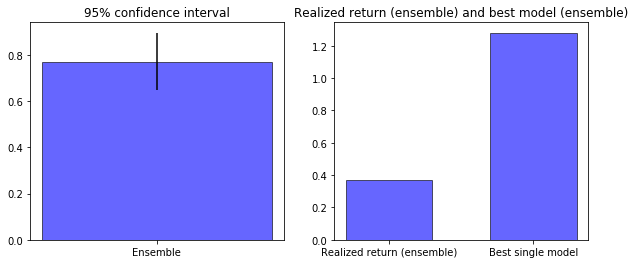

In [368]:
best_model = np.array(perfs).max()
yerr = 0.125
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.bar(np.arange(0,1,1), np.array(perfs).mean(), yerr=yerr,
        width=0.6, color='blue', edgecolor='black', alpha=0.6)
plt.title('95% confidence interval')
plt.xticks([0], labels=['Ensemble'])

plt.subplot(122)
plt.bar(np.arange(0,2,1), [ensemble_ret, best_model],
       width=0.6, color='blue', edgecolor='black', alpha=0.6)
plt.title('Realized return (ensemble) and best model (ensemble)')
plt.xticks([0, 1], labels=['Realized return (ensemble)', 'Best single model'])

## Appendix: comment on frictional costs

The results shown above are partially unrealistic: frictional costs have not been taken into account for the computation. A quick fix is stalling the model unless the action it wants to take is **identical** to the expert action of the same trading day.

In [364]:
it = next(iter(valloader))
probs = torch.zeros(it.size(0), 10).to(device)
for model in ensemble:
    probs += model(it[:,:-1,:-1].to(device))
_, predictions = torch.max(probs/len(ensemble), 1)

In [365]:
return_model = 0
n_buys = 0
for idx, el in enumerate(predictions):
    #if action not `Hold`
    if el != 0:
        action = el * 10 -1 # buy at label * 10 (tenors bin size: 10)
        # check if action is identical to expert's action
        if el == it[idx, -1, -1].item():
            return_model += rets[action, idx]
            n_buys += 1
ensemble_ret = return_model
ensemble_ret

0.37248504071170896

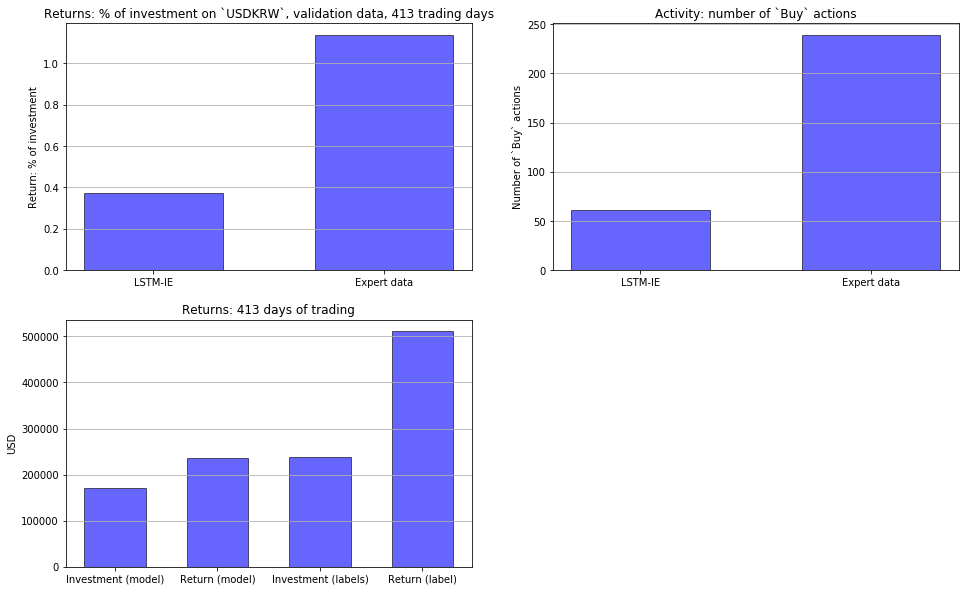

In [366]:
# n_trades:
activity_labels = torch.numel(it[:,-1,-1].nonzero()),
activity_model = torch.numel(b.nonzero())
activity_labels = activity_labels[0]

order_size = 1000

im = plt.figure(figsize=(16,10))
plt.subplot(221)
plt.bar(np.arange(0, 2, 1), [return_model, return_labels], \
        width=0.6, color='blue', edgecolor='black', alpha=0.6)

plt.xticks(ticks=[0, 1], labels=['LSTM-IE', 'Expert data']);
plt.ylabel('Return: % of investment')
plt.grid(axis='y')
plt.title('Returns: % of investment on `USDKRW`, validation data, 413 trading days')
plt.subplot(222)
plt.bar(np.arange(0, 2, 1), [n_buys, activity_labels], width=0.6, color='blue', \
        edgecolor='black', alpha=0.6)

plt.xticks(ticks=[0, 1], labels=['LSTM-IE', 'Expert data']);
plt.ylabel('Number of `Buy` actions')
plt.grid(axis='y')
plt.title('Activity: number of `Buy` actions')


plt.subplot(223)
plt.bar(np.arange(0, 4, 1), [order_size*activity_model, \
                             order_size*(1+return_model)*activity_model, \
                             order_size*activity_labels, \
                             order_size*(1+return_labels)*activity_labels], \
        width=0.6, color='blue', edgecolor='black', alpha=0.6)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Investment (model)', 'Return (model)', 'Investment (labels)', \
                                      'Return (label)']);
plt.ylabel('USD')
plt.grid(axis='y')
plt.title('Returns: 413 days of trading')
plt.savefig('trained SLSTM-I.jpg')

By blocking actions not present in the expert dataset we mute the effectiveness of the model, since its overall activity is reduced by a factor of 4. However, the results still show a positive ROI. 